In [31]:
from qiskit_nature.units import *   #ANGSTROM
from qiskit_nature.second_q.drivers import *    #PySCFDriver
from qiskit_nature.second_q.mappers import * #JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult
from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF
#from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options
from qiskit_algorithms.optimizers import * 
from qiskit_algorithms import VQE
from braket.tracking import Tracker
from qiskit_braket_provider import *
from qiskit_aer import StatevectorSimulator
from qiskit.primitives import Estimator
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_algorithms import AdaptVQE

import matplotlib.pyplot as plt
import numpy as np

In [19]:
"""
        Estamos criando algumas funções de comparação de tempo de processamento para diversos métodos.
        Criaremos para o h2 com (espaço ativo + tappering) e um h2 com (Espaço Ativo + Tapering + Adapt-VQE) 
"""


def h2_active_space(d):

    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
    estrutura_inicial = driver.run() #Criamos a estrutura do nosso sistema

    espaco_target = ActiveSpaceTransformer(2,2) #Active Space para o H2
    estrutura_otimizada = espaco_target.transform(estrutura_inicial) #mudando nossa hamiltoniana para o active space

    #Fazemos a redução por mapeamento e simetria
    mapper = estrutura_otimizada.get_tapered_mapper(BravyiKitaevMapper())

    ansatz = UCCSD(
        estrutura_otimizada.num_spatial_orbitals,
        estrutura_otimizada.num_particles,
        mapper,
        initial_state=HartreeFock(
            estrutura_otimizada.num_spatial_orbitals,
            estrutura_otimizada.num_particles,
            mapper))


    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    calculo = GroundStateEigensolver(mapper, vqe_solver)
    resultados = calculo.solve(estrutura_otimizada)

    return [resultados.groundenergy + resultados.nuclear_repulsion_energy, resultados.groundenergy, resultados.nuclear_repulsion_energy]

def h2_adapt(d):

    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
    estrutura_inicial = driver.run() #Criamos a estrutura do nosso sistema

    #Pegamos os espaço ativo
    espaco_target = ActiveSpaceTransformer(2,2) #Active Space para o H2
    estrutura_otimizada = espaco_target.transform(estrutura_inicial) #mudando nossa hamiltoniana para o active space

    #Fazemos a redução por mapeamento e simetria
    mapper = estrutura_otimizada.get_tapered_mapper(BravyiKitaevMapper())

    #Criação do Ansatz
    ansatz = UCCSD(
        estrutura_otimizada.num_spatial_orbitals,
        estrutura_otimizada.num_particles,
        mapper,
        initial_state=HartreeFock(
            estrutura_otimizada.num_spatial_orbitals,
            estrutura_otimizada.num_particles,
            mapper))

    #Configurando o VQE
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    #Fechando com o Adapt
    adapt_vqe = AdaptVQE(vqe_solver)
    adapt_vqe.supports_aux_operators = lambda: True

    #Calculando o GS da molécula
    calculo = GroundStateEigensolver(mapper, adapt_vqe)
    resultados = calculo.solve(estrutura_otimizada)

    return [resultados.groundenergy + resultados.nuclear_repulsion_energy, resultados.groundenergy, resultados.nuclear_repulsion_energy]

In [21]:
#Intervalo usado para a distância
intervalo = np.arange(0.3,3,0.1)
len(intervalo)


#Gerando os nossos valores para plot
h2_controle = [h2_active_space(d)[0] for d in intervalo]
h2_otimizado = [h2_adapt(d)[0] for d in intervalo]

27

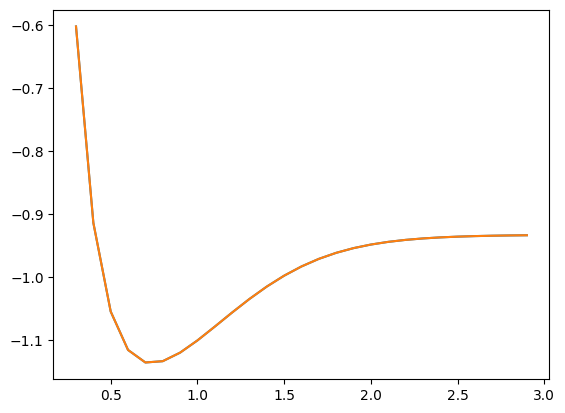

In [32]:
plt.plot(intervalo, h2_controle)
plt.plot(intervalo, h2_otimizado)

No nosso caso mais otimizado possivel (Active Space + Tapering) o uso do Adapt-VQE produz um efeito negativo aumentando o tempo de processamento, muito possivelmente por termos que adicionar um passo a mais em um processo que já esta o mais simples possivel.


Vamos observar como o Adapt-VQE performa em um caso um pouco mais complexo. Sem utilizar os métodos de performace.
H2 Default e H2 + Adapt VQE


In [33]:
def h2_padrao(d):

    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
    estrutura_inicial = driver.run() #Criamos a estrutura do nosso sistema

    mapper = BravyiKitaevMapper()
    
    #Criação do Ansatz
    ansatz = UCCSD(
        estrutura_inicial.num_spatial_orbitals,
        estrutura_inicial.num_particles,
        mapper,
        initial_state=HartreeFock(
            estrutura_inicial.num_spatial_orbitals,
            estrutura_inicial.num_particles,
            mapper))

    #Configurando o VQE
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    #Calculando o GS da molécula
    calculo = GroundStateEigensolver(mapper, vqe_solver)
    resultados = calculo.solve(estrutura_inicial)

    return resultados.groundenergy + resultados.nuclear_repulsion_energy

In [36]:
def h2_adaptado(d):

    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
    estrutura_inicial = driver.run() #Criamos a estrutura do nosso sistema

    mapper = BravyiKitaevMapper()
    
    #Criação do Ansatz
    ansatz = UCCSD(
        estrutura_inicial.num_spatial_orbitals,
        estrutura_inicial.num_particles,
        mapper,
        initial_state=HartreeFock(
            estrutura_inicial.num_spatial_orbitals,
            estrutura_inicial.num_particles,
            mapper))

    #Configurando o VQE
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    adapt_vqe = AdaptVQE(vqe_solver)
    adapt_vqe.supports_aux_operators = lambda: True

    #Calculando o GS da molécula
    calculo = GroundStateEigensolver(mapper, adapt_vqe)
    resultados = calculo.solve(estrutura_inicial)

    return resultados.groundenergy + resultados.nuclear_repulsion_energy

Marcação de tempo

In [39]:
%%timeit
h2_vqe = [h2_adaptado(a) for a in intervalo]

19 s ± 591 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit
h2_default = [h2_padrao(a) for a in intervalo]

27.5 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1]:
(27.5 - 19)/27.5

0.3090909090909091

O método onde usamos o Adapt VQE performou em um tempo 30% menor que o normal. sem perda na qualidade dos resultados.

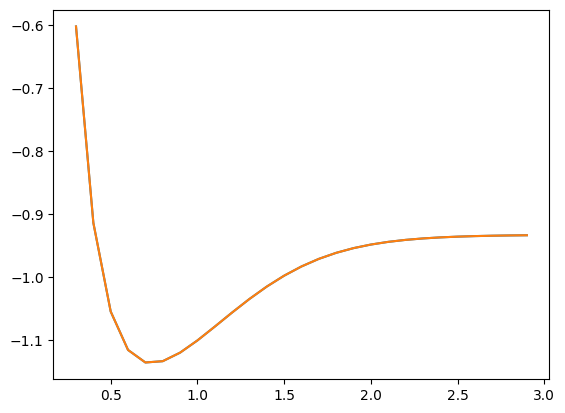

In [41]:
plt.plot(intervalo, h2_default)
plt.plot(intervalo, h2_vqe);